<a href="https://www.kaggle.com/code/parisrohan/rp-vehicledataset3-eda-dataprep-outlier-modelbuild?scriptVersionId=92104157" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/vehicle-dataset-from-cardekho/car data.csv
/kaggle/input/vehicle-dataset-from-cardekho/CAR DETAILS FROM CAR DEKHO.csv
/kaggle/input/vehicle-dataset-from-cardekho/Car details v3.csv


In [2]:
#import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats

from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error

pd.pandas.set_option('display.max_columns',None)
%matplotlib inline

In [3]:
#Load the dataset
df_data=pd.read_csv('/kaggle/input/vehicle-dataset-from-cardekho/Car details v3.csv')
df_data.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


In [4]:
#Check the data-type of each feature
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           8128 non-null   object 
 1   year           8128 non-null   int64  
 2   selling_price  8128 non-null   int64  
 3   km_driven      8128 non-null   int64  
 4   fuel           8128 non-null   object 
 5   seller_type    8128 non-null   object 
 6   transmission   8128 non-null   object 
 7   owner          8128 non-null   object 
 8   mileage        7907 non-null   object 
 9   engine         7907 non-null   object 
 10  max_power      7913 non-null   object 
 11  torque         7906 non-null   object 
 12  seats          7907 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 825.6+ KB


In [5]:
#Get the total number of rows and columns in dataset
df_data.shape

(8128, 13)

## Impute missing values

In [6]:
#Functon to get count of missing values in each column
def get_cols_with_missing_values(DataFrame):
    missing_na_columns=(DataFrame.isnull().sum())
    return missing_na_columns[missing_na_columns > 0]

In [7]:
print('Features having missing values are:')
print(get_cols_with_missing_values(df_data))

Features having missing values are:
mileage      221
engine       221
max_power    215
torque       222
seats        221
dtype: int64


In [8]:
#The 'mileage' feature has object data-type 
#The feature comprises of mileage number and the unit
#We will create a new feature named 'mileage_number' to get the actual number
#221/8128 values are missing - we will first create the above mentioned new feature and then impute the missing values

df_data[['mileage_number', 'mileage_unit']] = df_data['mileage'].str.split(' ', 1, expand=True)
df_data.drop(['mileage_unit', 'mileage'],axis=1,inplace=True)

df_data['mileage_number']=df_data['mileage_number'].astype('float')

#impute the missing values
df_data['mileage_number']=df_data['mileage_number'].fillna(df_data['mileage_number'].mean())

In [9]:
#The 'engine' feature has object data-type 
#The feature comprises of a number and a unit
#We will create a new feature named 'engine_op_number' to get the actual number
#221/8128 values are missing - we will first create the above mentioned new feature and then impute the missing values

df_data[['engine_op_number', 'engine_op_unit']] = df_data['engine'].str.split(' ', 1, expand=True)
df_data.drop(['engine_op_unit', 'engine'],axis=1,inplace=True)

df_data['engine_op_number']=df_data['engine_op_number'].astype('float')

#impute the missing values
df_data['engine_op_number']=df_data['engine_op_number'].fillna(df_data['engine_op_number'].mean())

In [10]:
#The 'max_power' feature has object data-type 
#The feature comprises of a number and a unit
#We will create a new feature named 'max_power_number' to get the actual number
#221/8128 values are missing - we will first create the above mentioned new feature and then impute the missing values

df_data[['max_power_number', 'max_power_unit']] = df_data['max_power'].str.split(' ', 1, expand=True)
df_data.drop(['max_power_unit', 'max_power'],axis=1,inplace=True)

df_data['max_power_number'].replace({'': 0}, inplace=True)

df_data['max_power_number'] = df_data['max_power_number'].fillna(df_data['max_power_number'].mode()[0])

df_data['max_power_number']=df_data['max_power_number'].astype('float')

In [11]:
#torque feature
df_data[['torque', 'torque_remainder']] = df_data['torque'].str.split('@', 1, expand=True)
df_data.drop(['torque_remainder'],axis=1,inplace=True)

df_data['torque']= df_data['torque'].str.extract('(^\d*)')

df_data['torque']= df_data['torque'].fillna(150)
df_data['torque']=df_data['torque'].astype('int')

#if it's in kgm, change it to N.m by multiplying by g= 9.8 -> 1 kg-m is equal to 9.80665 newton meter.
df_data['torque'] = df_data['torque'].apply(lambda x: 9.8*x if x <= 50 else x)

In [12]:
#seats feature
df_data['seats']=df_data['seats'].fillna(df_data['seats'].mean())

In [13]:
#Drop the name feature
df_data.drop(['name'], axis=1, inplace=True)

In [14]:
#Get categorical and numerical columns
categorical_cols=[cname for cname in df_data.columns if df_data[cname].dtypes=='object']
numerical_cols=[cname for cname in df_data.columns if df_data[cname].dtypes!='object']

In [15]:
print('Categorical features:',categorical_cols,'\n')
print('Numerical features:',numerical_cols)

Categorical features: ['fuel', 'seller_type', 'transmission', 'owner'] 

Numerical features: ['year', 'selling_price', 'km_driven', 'torque', 'seats', 'mileage_number', 'engine_op_number', 'max_power_number']


## EDA

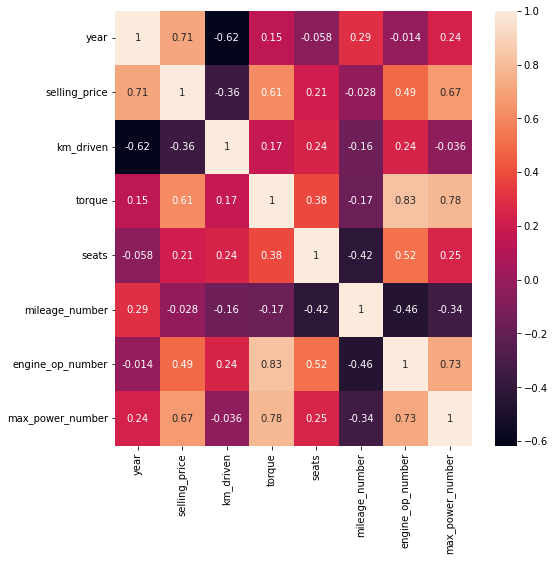

In [16]:
corrmat = df_data.corr(method = "spearman")
plt.figure(figsize=(8,8))
#plot heat map
g=sns.heatmap(corrmat,annot=True)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


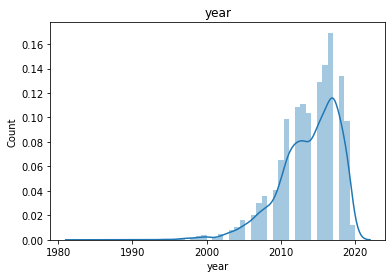

<Figure size 1080x1080 with 0 Axes>

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


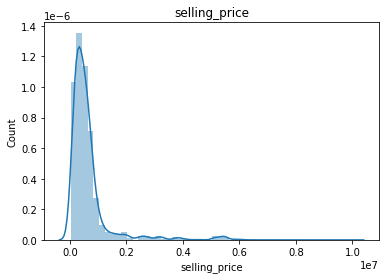

<Figure size 1080x1080 with 0 Axes>

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


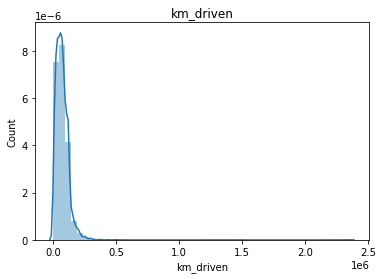

<Figure size 1080x1080 with 0 Axes>

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


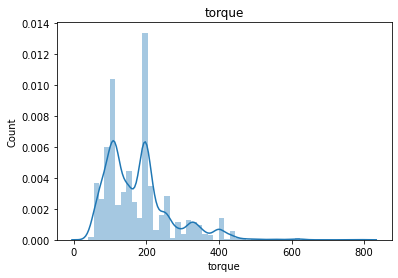

<Figure size 1080x1080 with 0 Axes>

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


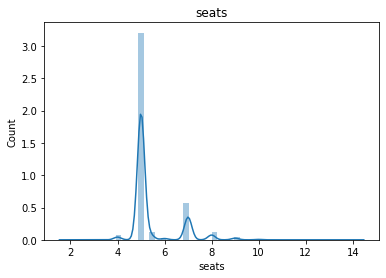

<Figure size 1080x1080 with 0 Axes>

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


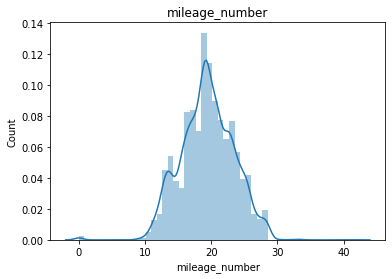

<Figure size 1080x1080 with 0 Axes>

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


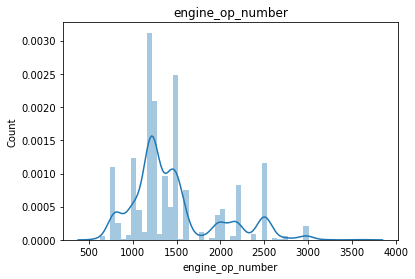

<Figure size 1080x1080 with 0 Axes>

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


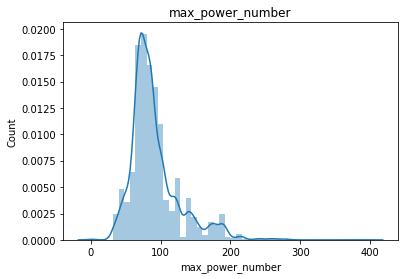

<Figure size 1080x1080 with 0 Axes>

In [17]:
#Numeric data distribution
for feature in numerical_cols:
    sns.distplot(df_data[feature])
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.title(feature)
    plt.figure(figsize=(15,15))
    plt.show()

Text(0.5, 1.0, 'Distribution fuel type')

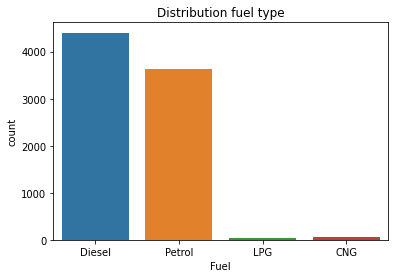

In [18]:
#Distribution fuel type
sns.countplot(x='fuel', data=df_data)
plt.xlabel('Fuel')
plt.title('Distribution fuel type')

Text(0.5, 1.0, 'Seller Type')

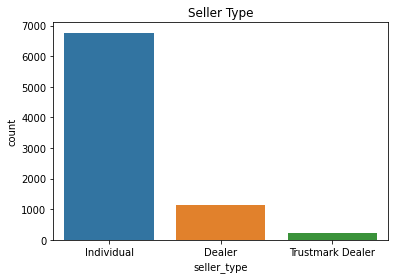

In [19]:
#Seller Type
sns.countplot(x='seller_type', data=df_data)
plt.title('Seller Type')

Text(0.5, 1.0, 'Engine Transmission')

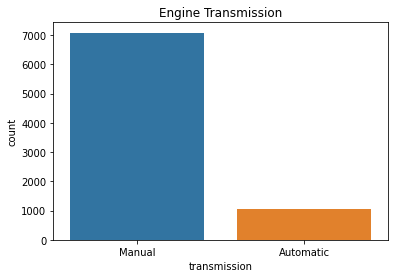

In [20]:
#Engine Transmission
sns.countplot(x='transmission', data=df_data)
plt.title('Engine Transmission')

Text(0.5, 1.0, 'Transmission-fuel')

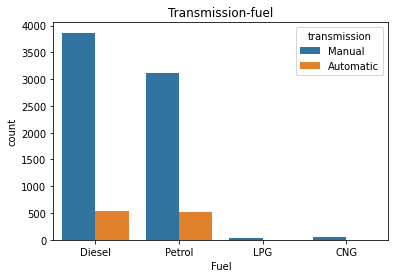

In [21]:
#Transmission-fuel
sns.countplot(x='fuel', data=df_data, hue='transmission')
plt.xlabel('Fuel')
plt.title('Transmission-fuel')

Text(0.5, 1.0, 'Owner')

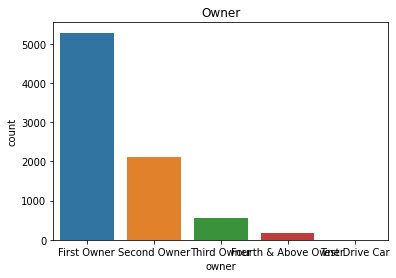

In [22]:
#Engine Transmission
sns.countplot(x='owner', data=df_data)
plt.title('Owner')

## Handling Outliers

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn

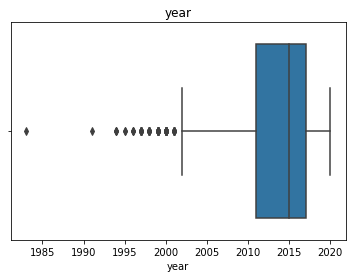

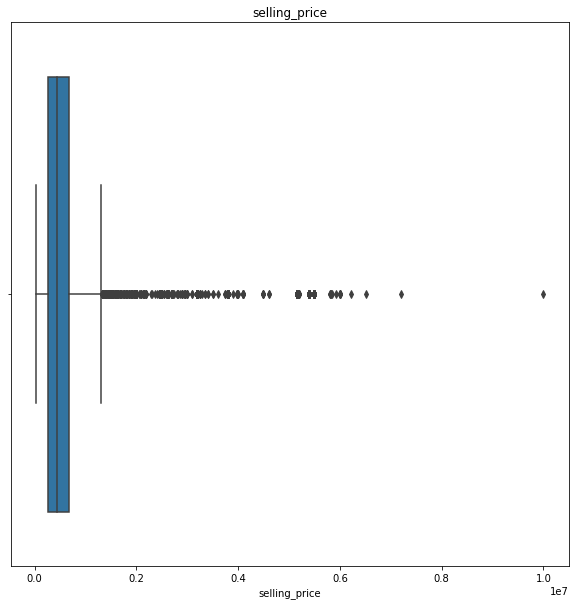

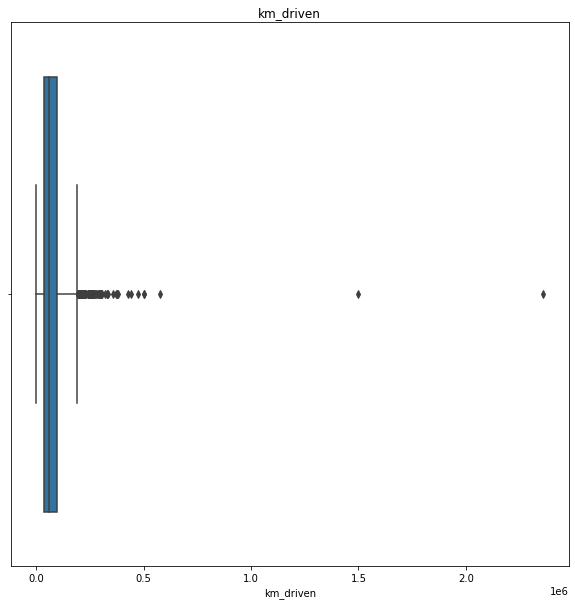

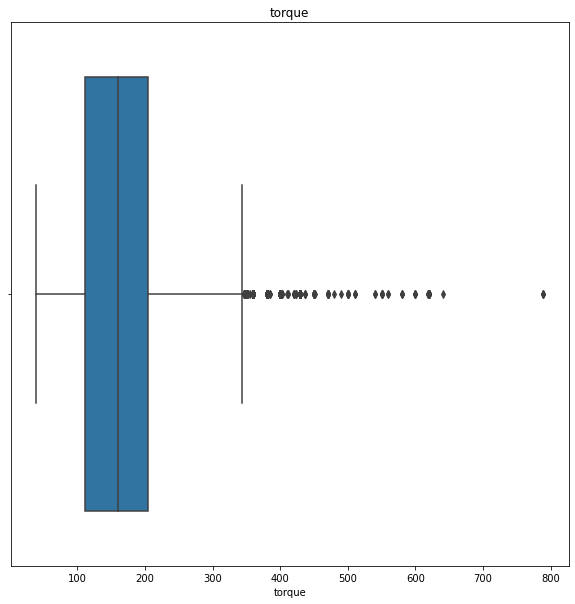

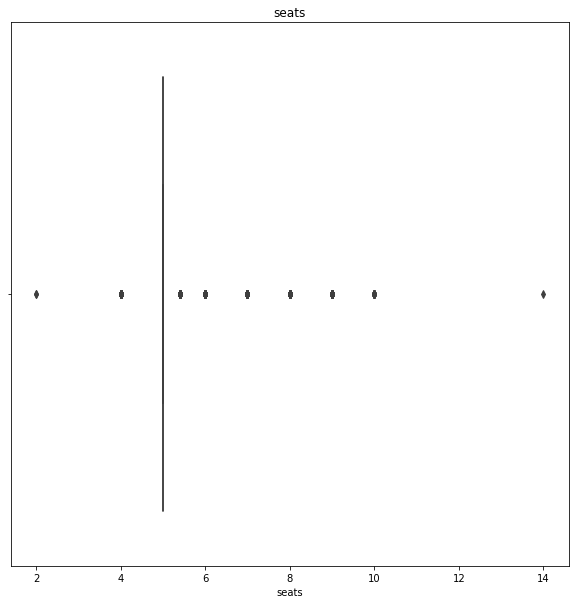

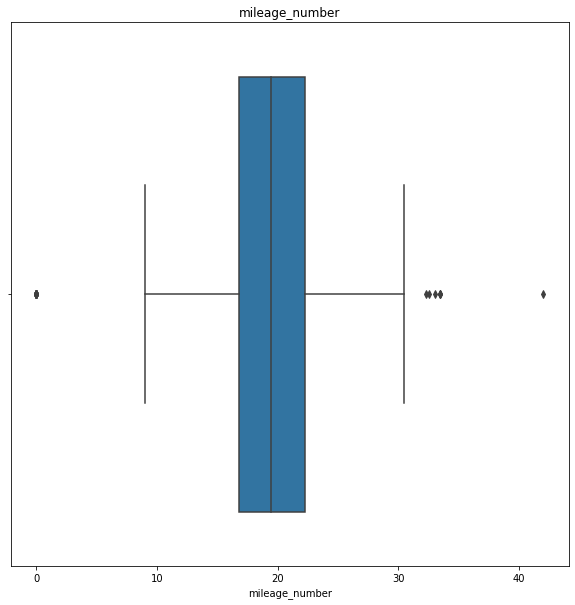

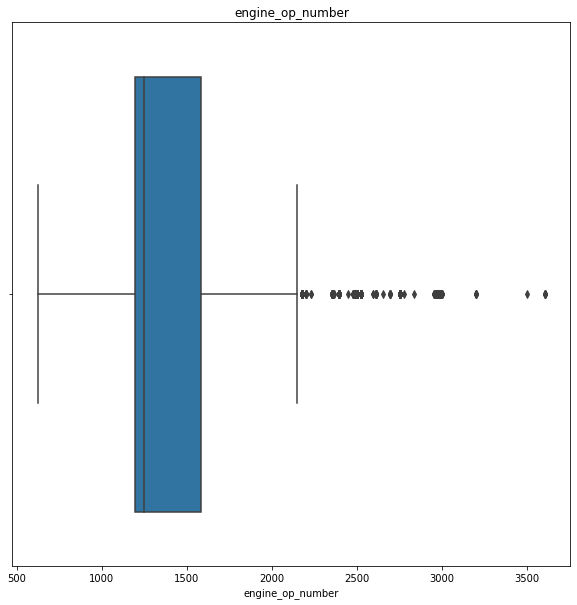

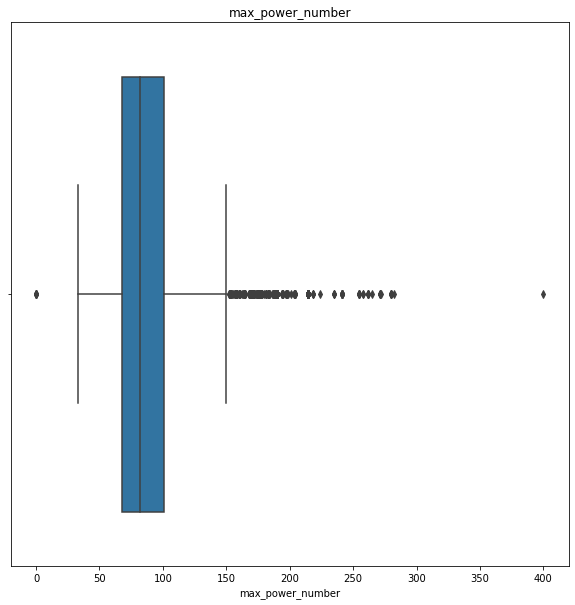

<Figure size 720x720 with 0 Axes>

In [23]:
for feature in numerical_cols:
    sns.boxplot(df_data[feature])
    plt.title(feature)
    plt.figure(figsize=(10,10))

In [24]:
#Handling outliers in 'year'
IQR=df_data.year.quantile(0.75)-df_data.year.quantile(0.25)
lower_limit=df_data.year.quantile(0.25)-(IQR*1.5)
upper_limit=df_data.year.quantile(0.75)+(IQR*1.5)
print(lower_limit, upper_limit)

2002.0 2026.0


In [25]:
df_data.loc[df_data['year']>=2026.0,'year']=2026.0
df_data.loc[df_data['year']<=2002.0,'year']=2002.0

In [26]:
#Handling outliers in 'selling_price'
IQR=df_data.selling_price.quantile(0.75)-df_data.selling_price.quantile(0.25)
lower_limit=df_data.selling_price.quantile(0.25)-(IQR*1.5)
upper_limit=df_data.selling_price.quantile(0.75)+(IQR*1.5)
print(lower_limit, upper_limit)

-375002.5 1305001.5


In [27]:
df_data.loc[df_data['selling_price']<=-375002.5,'selling_price']=-375002.5
df_data.loc[df_data['selling_price']>=1305001.5,'selling_price']=1305001.5

In [28]:
#Handling outliers in 'km_driven'
IQR=df_data.km_driven.quantile(0.75)-df_data.km_driven.quantile(0.25)
lower_limit=df_data.km_driven.quantile(0.25)-(IQR*1.5)
upper_limit=df_data.km_driven.quantile(0.75)+(IQR*1.5)
print(lower_limit, upper_limit)

-59500.0 192500.0


In [29]:
df_data.loc[df_data['km_driven']<=-59500.0,'km_driven']=-59500.0
df_data.loc[df_data['km_driven']>=192500.0,'km_driven']=192500.0

In [30]:
#Handling outliers in 'torque'
IQR=df_data.torque.quantile(0.75)-df_data.torque.quantile(0.25)
lower_limit=df_data.torque.quantile(0.25)-(IQR*1.5)
upper_limit=df_data.torque.quantile(0.75)+(IQR*1.5)
print(lower_limit, upper_limit)

-27.5 344.5


In [31]:
df_data.loc[df_data['torque']<=-27.5,'torque']=-27.5
df_data.loc[df_data['torque']>=344.5,'torque']=344.5

In [32]:
#Handling outliers in 'mileage_number'
IQR=df_data.mileage_number.quantile(0.75)-df_data.mileage_number.quantile(0.25)
lower_limit=df_data.mileage_number.quantile(0.25)-(IQR*1.5)
upper_limit=df_data.mileage_number.quantile(0.75)+(IQR*1.5)
print(lower_limit, upper_limit)

8.583750000000002 30.49375


In [33]:
df_data.loc[df_data['mileage_number']<=8.58,'mileage_number']=8.58
df_data.loc[df_data['mileage_number']>=30.49,'mileage_number']=30.49

In [34]:
#Handling outliers in 'engine_op_number'
IQR=df_data.engine_op_number.quantile(0.75)-df_data.engine_op_number.quantile(0.25)
lower_limit=df_data.engine_op_number.quantile(0.25)-(IQR*1.5)
upper_limit=df_data.engine_op_number.quantile(0.75)+(IQR*1.5)
print(lower_limit, upper_limit)

619.5 2159.5


In [35]:
df_data.loc[df_data['engine_op_number']<=619.5,'engine_op_number']=619.5
df_data.loc[df_data['engine_op_number']>=2159.5,'engine_op_number']=2159.5

In [36]:
#Handling outliers in 'max_power_number'
IQR=df_data.max_power_number.quantile(0.75)-df_data.max_power_number.quantile(0.25)
lower_limit=df_data.max_power_number.quantile(0.25)-(IQR*1.5)
upper_limit=df_data.max_power_number.quantile(0.75)+(IQR*1.5)
print(lower_limit, upper_limit)

18.374999999999986 150.97500000000002


In [37]:
df_data.loc[df_data['max_power_number']<=18.37,'max_power_number']=18.37
df_data.loc[df_data['max_power_number']>=150.97,'max_power_number']=150.97

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn

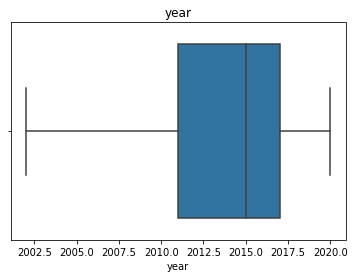

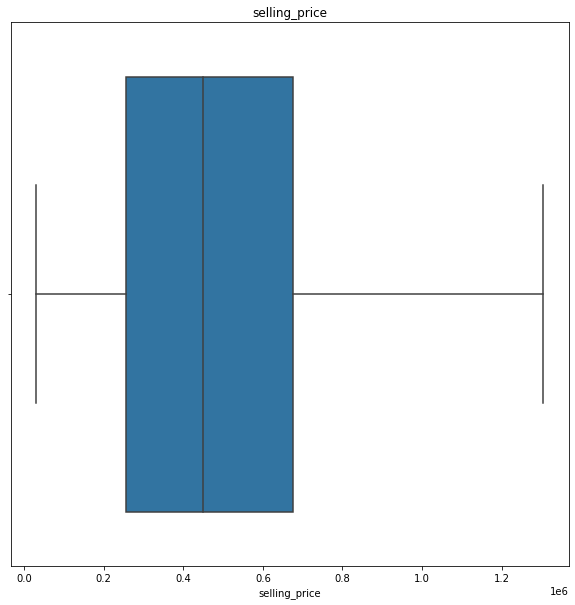

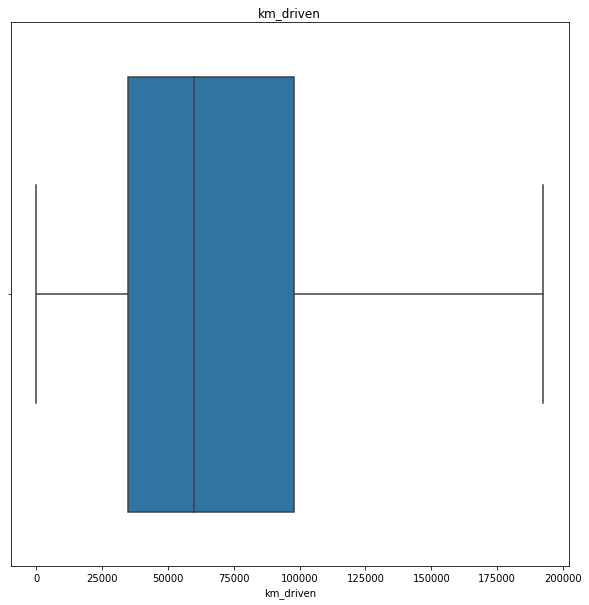

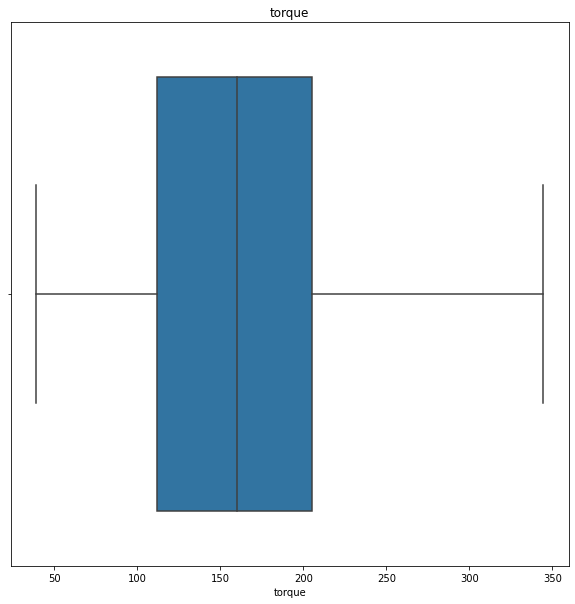

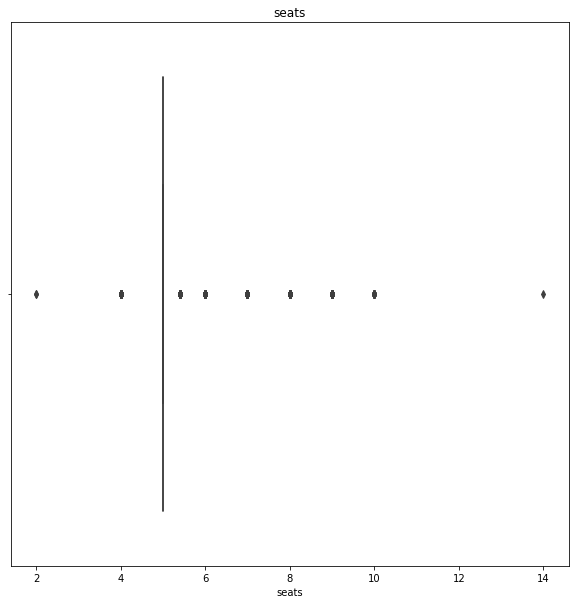

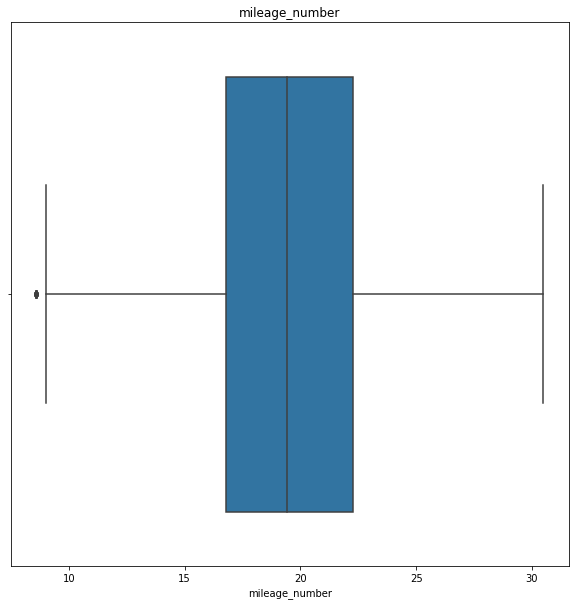

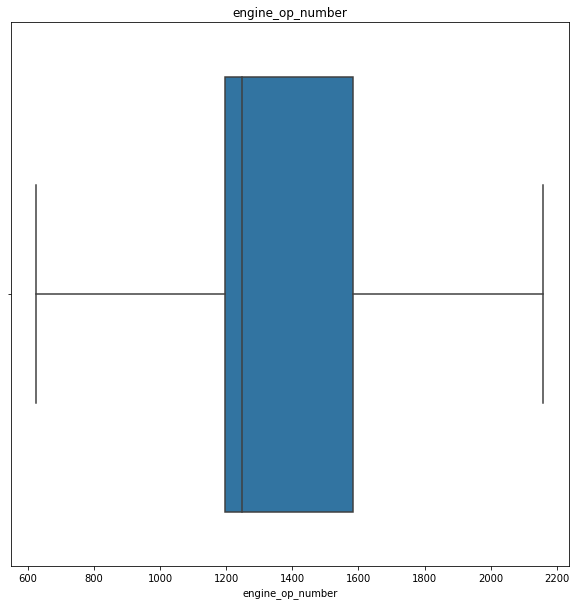

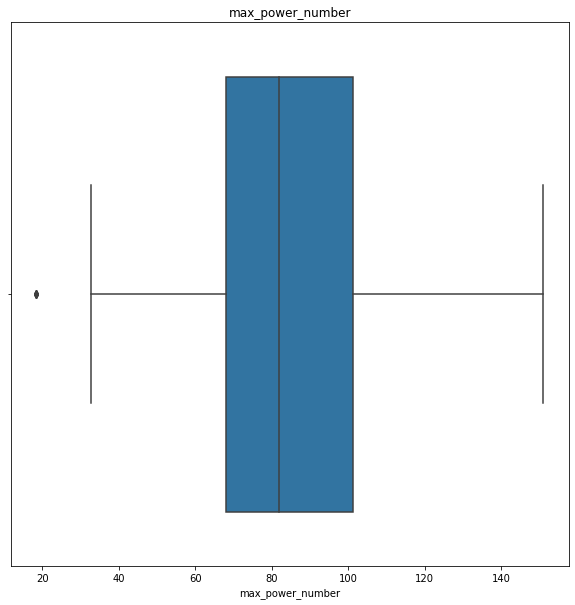

<Figure size 720x720 with 0 Axes>

In [38]:
for feature in numerical_cols:
    sns.boxplot(df_data[feature])
    plt.title(feature)
    plt.figure(figsize=(10,10))

## Feature Engineering

In [39]:
#Create a feature named 'Car_age' which is current_year-'year'

from datetime import date
todays_date = date.today()
print("Current year:", todays_date.year)

df_data['Car_age']=todays_date.year-df_data['year']

df_data.drop('year', axis=1, inplace=True)

Current year: 2022


In [40]:
bins = [1, 6, 11, 16, 21, 26, 31, 36, 41]
group_names = ['1-5', '6-10', '11-15', '16-20', '21-25', '26-30', '31-35', '36-40']
car_age_categories = pd.cut(df_data['Car_age'], bins, labels=group_names)
df_data['car_age_categories'] = pd.cut(df_data['Car_age'], bins, labels=group_names)
car_age_categories
pd.value_counts(df_data['car_age_categories'])

1-5      3341
6-10     3310
11-15    1161
16-20     316
21-25       0
26-30       0
31-35       0
36-40       0
Name: car_age_categories, dtype: int64

In [41]:
df_data.drop('Car_age', axis=1, inplace=True)
df_data['car_age_categories']=df_data['car_age_categories'].astype('object')

## Feature Transformation

In [42]:
df_data.describe()

,selling_price,km_driven,torque,seats,mileage_number,engine_op_number,max_power_number
count,8.128000e+03,8128.000000,8128.000000,8128.000000,8128.000000,8128.000000,8128.000000
mean,5.155124e+05,68311.382013,172.420349,5.416719,19.433447,1416.605638,88.603764
std,3.337026e+05,43569.154403,78.545915,0.946450,3.901054,406.157367,28.614184
min,2.999900e+04,1.000000,39.200000,2.000000,8.580000,624.000000,18.370000
25%,2.549990e+05,35000.000000,112.000000,5.000000,16.800000,1197.000000,68.100000
50%,4.500000e+05,60000.000000,160.000000,5.000000,19.418783,1248.000000,81.860000
75%,6.750000e+05,98000.000000,205.000000,5.000000,22.277500,1582.000000,101.250000
max,1.305002e+06,192500.000000,344.500000,14.000000,30.490000,2159.500000,150.970000


array([[<AxesSubplot:title={'center':'selling_price'}>,
        <AxesSubplot:title={'center':'km_driven'}>,
        <AxesSubplot:title={'center':'torque'}>],
       [<AxesSubplot:title={'center':'seats'}>,
        <AxesSubplot:title={'center':'mileage_number'}>,
        <AxesSubplot:title={'center':'engine_op_number'}>],
       [<AxesSubplot:title={'center':'max_power_number'}>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

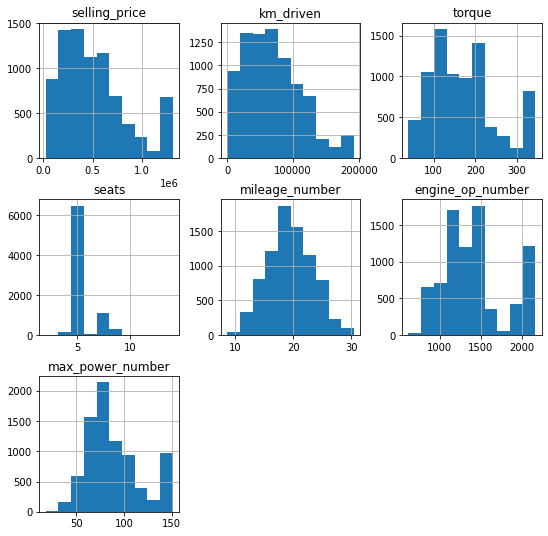

In [43]:
#data distribution in df
df_data.hist(figsize=(9, 9))

In [44]:
numerical_cols = [cname for cname in df_data.columns if df_data[cname].dtypes!='object' and cname!='selling_price']
skew_df = pd.DataFrame(numerical_cols, columns=['Feature'])
skew_df['Skew'] = skew_df['Feature'].apply(lambda feature: scipy.stats.skew(df_data[feature]))
skew_df['Absolute Skew'] = skew_df['Skew'].apply(abs)
skew_df['Skewed'] = skew_df['Absolute Skew'].apply(lambda x: True if x >= 0.5 else False)
skew_df

,Feature,Skew,Absolute Skew,Skewed
0,km_driven,0.741845,0.741845,True
1,torque,0.690393,0.690393,True
2,seats,1.996875,1.996875,True
3,mileage_number,0.012524,0.012524,False
4,engine_op_number,0.614328,0.614328,True
5,max_power_number,0.768951,0.768951,True


## Encoding categorical features

In [45]:
categorical_cols=[cname for cname in df_data.columns if df_data[cname].dtypes=='object']
print(categorical_cols)

['fuel', 'seller_type', 'transmission', 'owner', 'car_age_categories']


In [46]:
df_data2=df_data.copy(deep=True)
df_data_encoded = pd.get_dummies(df_data2[categorical_cols],drop_first=True)
df_data2.drop(categorical_cols,axis=1,inplace=True)
df_data2 = pd.concat([df_data2,df_data_encoded],axis=1)

df_data2.head()

,selling_price,km_driven,torque,seats,mileage_number,engine_op_number,max_power_number,fuel_Diesel,fuel_LPG,fuel_Petrol,seller_type_Individual,seller_type_Trustmark Dealer,transmission_Manual,owner_Fourth & Above Owner,owner_Second Owner,owner_Test Drive Car,owner_Third Owner,car_age_categories_11-15,car_age_categories_16-20,car_age_categories_6-10
0,450000.0,145500,190.0,5.0,23.40,1248.0,74.00,1,0,0,1,0,1,0,0,0,0,0,0,1
1,370000.0,120000,250.0,5.0,21.14,1498.0,103.52,1,0,0,1,0,1,0,1,0,0,0,0,1
2,158000.0,140000,117.6,5.0,17.70,1497.0,78.00,0,0,1,1,0,1,0,0,0,1,1,0,0
3,225000.0,127000,215.6,5.0,23.00,1396.0,90.00,1,0,0,1,0,1,0,0,0,0,1,0,0
4,130000.0,120000,107.8,5.0,16.10,1298.0,88.20,0,0,1,1,0,1,0,0,0,0,1,0,0


## Model Building

In [47]:
X = df_data2.loc[:, df_data2.columns!='selling_price']
y = df_data2['selling_price']

In [48]:
# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=0)
# summarize
print('Train', X_train.shape, y_train.shape)
print('Test', X_valid.shape, y_valid.shape)

Train (5689, 19) (5689,)
Test (2439, 19) (2439,)


In [49]:
#xgb_model=XGBRegressor(n_estimators=1000, larning_rate=0.05, n_jobs=-1)
#xgb_model.fit(X_train, y_train, early_stopping_rounds=5, eval_set=[(X_valid, y_valid)], verbose=False)

In [50]:
# A parameter grid for XGBoost
params = {
    'n_estimators':[200*i for i in range(1,5)],
    'min_child_weight':[2*i+1 for i in range(0,5)], 
    'gamma':[0.1*i for i in range(1,10)],  
    'subsample':[0.1*i for i in range(6,11)],
    'colsample_bytree':[0.1*i for i in range(6,11)], 
    'max_depth': [2,3,4,6,7],
    'objective': ['reg:squarederror', 'reg:tweedie'],
    'booster': ['gbtree', 'gblinear'],
    'eval_metric': ['rmse'],
    'eta': [0.1*i for i in range(3,6)],
}

In [51]:
regressor = XGBRegressor()
#RandomizedSearchCV
random_search = RandomizedSearchCV(regressor, param_distributions=params,n_iter=5, n_jobs=-1, cv=5, scoring='neg_mean_squared_error')

random_search.fit(X_train, y_train)

[18:50:48] WARNING: ../src/learner.cc:576: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          enable_categorical=False, gamma=None,
                                          gpu_id=None, importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=...
                                        'eta': [0.30000000000000004, 0.4, 0.5],
                                        'eval_metric': ['rmse'],
                                        'gamma

In [52]:
best_regressor = random_search.best_estimator_

In [53]:
pred=best_regressor.predict(X_valid)

In [54]:
print(np.sqrt(mean_absolute_error(y_valid,pred)))

343.4722803178751


Old RMSE:
1. 250.74